In [18]:
import math 
# import pys2let as ps 
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
from s2wav import filters
import healpy as hp
import numpy as np
import s2wav
import skyclean
import time
import math
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline 

In [19]:
def check_and_create_ilc_directories():
    """
    Checks for the existence of a specific nested directory structure for ILC processing and creates any missing directories.
    This includes handling multiple levels of nested directories as shown in the provided folder structure.

    The structure checked is:
    - ILC
      - covariance_matrix
      - ILC_doubled_maps
      - ILC_processed_wavelet_maps
      - synthesized_ILC_MW_maps
      - wavelet_doubled
      - weight_vector_data
    """

    # Define the root directories
    # base_dir = "path_to_base_directory"  # Set this to your base directory path
    # ilc_dir = os.path.join(base_dir, "ILC")
    ilc_dir = "ILC"
    # List of directories under the ILC directory
    ilc_sub_dirs = ["covariance_matrix", "ILC_doubled_maps", "ILC_processed_wavelet_maps", "synthesized_ILC_MW_maps","wavelet_doubled","weight_vector_data"]

    # Create the ILC directory and its subdirectories
    create_directory(ilc_dir)
    for sub_dir in ilc_sub_dirs:
        create_directory(os.path.join(ilc_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed
check_and_create_ilc_directories()


Directory already exists: ILC
Directory already exists: ILC/covariance_matrix
Directory already exists: ILC/ILC_doubled_maps
Directory already exists: ILC/ILC_processed_wavelet_maps
Directory already exists: ILC/synthesized_ILC_MW_maps
Directory already exists: ILC/wavelet_doubled
Directory already exists: ILC/weight_vector_data


In [20]:

def mw_alm_2_hp_alm(MW_alm, lmax):
    """
    Converts MW alm coefficients to HEALPix alm coefficients.

    Args:
        MW_alm (ndarray): 2D array of shape (Lmax, 2*Lmax-1) representing MW alm coefficients.
        lmax (int): Maximum multipole moment.

    Returns:
        ndarray: 1D array of HEALPix alm coefficients.
    """
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

def Single_Map_doubleworker(MW_Pix_Map):
    """
    Doubles the resolution of a single wavelet map.

    Args:
        MW_Pix_Map (ndarray): Wavelet pixel map to be doubled in resolution.

    Returns:
        ndarray: Doubled resolution wavelet map.
    """
    MW_alm = s2fft.forward(MW_Pix_Map, L=MW_Pix_Map.shape[1])
    L = MW_alm.shape[0]
    padded_alm = np.zeros((2*L-1, 2*(2*L-1)-1), dtype=np.complex128)
    
    inner_matrix_middle = MW_alm.shape[1] // 2
    outer_matrix_middle = padded_alm.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + MW_alm.shape[1]
      
    padded_alm[:MW_alm.shape[0], start_col:end_col] = MW_alm
    MW_Pix_Map_doubled = np.real(s2fft.inverse(padded_alm, L=padded_alm.shape[0]))
    
    return MW_Pix_Map_doubled

def load_frequency_data(file_template, frequencies, scales, realization, component):
    """
    Loads wavelet data from files for different frequencies and scales.

    Args:
        base_path (str): Base directory containing the wavelet files.
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): Realization identifier as a string.

    Returns:
        dict: Dictionary where keys are tuples (frequency, scale) and values are loaded wavelet data arrays.
    """
    
    frequency_data = {}
    realization = str(realization).zfill(4)
    for frequency in frequencies:
        for scale in scales:
            path = f"{file_template.format(frequency=frequency, scale=scale, realization=realization, component=component)}"
            # print(path)
            try:
                frequency_data[(frequency, scale)] = np.load(path)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}, realization {realization}")
    return frequency_data

def save_doubled_wavelet_map(args):
    """
    Helper function to save a doubled wavelet map.

    Args:
        args (tuple): (wavelet_map, frequency, scale, realization, component, path_template)
    """
    original_map, frequency, scale, realization, component, path_template = args
    doubled_map = Single_Map_doubleworker(original_map)
    save_path = path_template.format(
        component=component,
        frequency=frequency,
        scale=scale,
        realization=realization
    )
    np.save(save_path, doubled_map)


def double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization, component, path_template):
    """
    Doubles the resolution of the wavelet coefficient maps using multiprocessing.

    Args:
        original_wavelet_c_j (dict): Dictionary containing the original wavelet maps.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): The realization number for file naming.
        path_template (str): Template for saving the doubled wavelet maps.
    """
    tasks = [(original_wavelet_c_j[(i, j)], i, j, realization, component, path_template) for i in frequencies for j in scales]
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(save_doubled_wavelet_map, tasks)

def smoothed_covariance(MW_Map1, MW_Map2):
    """
    Computes covariance between two wavelet maps with smoothing.

    Args:
        MW_Map1 (ndarray): First wavelet coefficient map.
        MW_Map2 (ndarray): Second wavelet coefficient map.

    Returns:
        ndarray: Smoothed covariance map.
    """
    smoothing_lmax = MW_Map1.shape[0]
    map1 = np.real(MW_Map1)
    map2 = np.real(MW_Map2)
    R_MW_Pixel_map = np.multiply(map1, map2) + 0.j

    R_MW_alm = s2fft.forward(R_MW_Pixel_map, L=smoothing_lmax)
    nsamp = 1200.0
    lmax_at_scale_j = R_MW_alm.shape[0]
    npix = hp.nside2npix(1 << (int(0.5*lmax_at_scale_j)-1).bit_length())
    scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
    gauss_smooth = hp.gauss_beam(scale_fwhm, lmax=smoothing_lmax-1)
    MW_alm_beam_convolved = np.zeros(R_MW_alm.shape, dtype=np.complex128)

    for i in range(R_MW_alm.shape[1]):
        MW_alm_beam_convolved[:, i] = R_MW_alm[:, i] * gauss_smooth
    
    R_covariance_map = np.real(s2fft.inverse(MW_alm_beam_convolved, L=smoothing_lmax))
    return R_covariance_map


def compute_covariance(task):
    """
    Computes the covariance between two frequency maps at a given scale.
    
    Args:
    task (tuple): A tuple containing (i, fq, frequencies, scale, doubled_MW_wav_c_j).
    
    Returns:
    tuple: A tuple containing indices i, fq and the computed covariance matrix.
    """
    i, fq, frequencies, scale, doubled_MW_wav_c_j = task
    key_i = (frequencies[i], scale)
    key_fq = (frequencies[fq], scale)
    if key_i not in doubled_MW_wav_c_j or key_fq not in doubled_MW_wav_c_j:
        raise KeyError(f"Missing data for keys {key_i} or {key_fq}.")
    return i, fq, smoothed_covariance(doubled_MW_wav_c_j[key_i], doubled_MW_wav_c_j[key_fq])

def calculate_covariance_matrix_MP(frequencies, doubled_MW_wav_c_j, scale, realization, component, path_template):
    """
    Calculates the covariance matrices for all given frequencies and saves them to disk using a provided template.
    """

    if frequencies:
        sample_data = doubled_MW_wav_c_j.get((frequencies[0], scale))
        if sample_data is None:
            raise KeyError(f"Data for frequency '{frequencies[0]}' and scale '{scale}' is missing.")
        n_rows, n_cols = sample_data.shape
    else:
        raise ValueError("Frequency list is empty.")
    
    total_frequency = len(frequencies)
    full_array = np.zeros((total_frequency, total_frequency, n_rows, n_cols))
    
    # Calculate the covariance (keep your existing logic)
    tasks = [(i, fq, frequencies, scale, doubled_MW_wav_c_j) 
             for i in range(total_frequency) for fq in range(i, total_frequency)]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(compute_covariance, tasks)
        for result in results:
            i, fq, covariance_matrix = result
            full_array[i, fq] = covariance_matrix
    
    # Fill the symmetric part of the matrix
    for l1 in range(1, total_frequency):
        for l2 in range(l1):
            full_array[l1, l2] = full_array[l2, l1]

    # ✅ Fixed: include component in format to prevent KeyError
    f_str = '_'.join(frequencies)
    save_path = path_template.format(
        component=component,
        frequencies=f_str, 
        scale=scale, 
        realization=str(realization).zfill(4)   
    )
    np.save(save_path, full_array)

    return full_array


def compute_weight_vector(R, scale, realization, weight_vector_matrix_template):
    """
    Processes the given 4D matrix R by computing and saving the weight vectors for each matrix in the first two dimensions.
    
    Args:
        R (np.ndarray): The input covariance matrix, either 2D or 4D.
        scale (int): The scale index.
        realization (str): The realization identifier.
        weight_vector_matrix_template (str): Template for saving the weight vector matrices.

    Returns:
        Returns:
        inverses: (np.ndarray): An Array containing the inverse matrices
        weight_vectors (np.ndarray): A 3D Array containing the weight vector.
        The size of the first two dimensions of the weight vector is the size of the wavelet coefficient map at the given scale.
        The third dimension is the weight vector (The contribution from each frequency).
        Each element of the weight vector is a 1D array.
        singular_matrices_location (list): The locations of singular matrices.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    identity_vector = np.ones(subdim2, dtype=float)
    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                if R.ndim == 4:
                    inverse_matrix = np.linalg.inv(R_Pix[i, j])
                    inverses[i, j] = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors[i, j] = numerator / denominator
                else:
                    inverse_matrix = np.linalg.inv(R_Pix)
                    inverses = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors = numerator / denominator
            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j
                )
                np.save(singular_matrix_path, R_Pix[i, j] if R.ndim == 4 else R_Pix)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(len(identity_vector))
                else:
                    weight_vectors = np.zeros(len(identity_vector))

    np.save(weight_vector_matrix_template.format(type="weight_vector", scale=scale, realization=realization), weight_vectors)
    return inverses, weight_vectors, singular_matrices_location

def process_matrix_worker(args):
    """
    Worker function for processing a single matrix in parallel.

    Args:
        args (tuple): Arguments including the matrix to process, indices, and paths for saving.
    """
    R_Pix_ij, i, j, scale, realization, identity_vector, inverses, weight_vectors, singular_matrices_location, component, component_name, path_template = args
    
    try:
        inverses[i, j] = np.linalg.inv(R_Pix_ij)
        numerator = np.dot(inverses[i, j], identity_vector)
        denominator = np.dot(numerator, identity_vector)
        weight_vectors[i, j] = numerator / denominator
    except np.linalg.LinAlgError:
        singular_matrices_location.append((i, j))
        np.save(path_template.format(type="inverse_singular_matrix", component=component, component_name=component_name, scale=scale, realization=realization, i=i, j=j), R_Pix_ij)
        weight_vectors[i, j] = np.zeros(len(identity_vector))




def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[scale][i, j], pix_vector)

def create_doubled_ILC_map(
    frequencies, scale, weight_vector_load, doubled_MW_wav_c_j,
    realization, component=None, constraint=False, component_name=None
):
    size = doubled_MW_wav_c_j[(frequencies[0], scale)].shape
    doubled_map = np.zeros(size)

    for i in range(size[0]):
        for j in range(size[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(
                i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j
            )

    # ✅ Save with proper file naming
    if constraint and component_name is not None:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy"
    else:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization}_MP.npy"

    np.save(path, doubled_map)
    return doubled_map


def trim_to_original(MW_Doubled_Map, scale, realization, component, component_name, path_template):
    """
    Trims the doubled MW map to its original resolution and saves it.

    Args:
        MW_Doubled_Map (ndarray): Doubled wavelet map to be trimmed.
        scale (int): Scale index.
        realization (str or int): The realization number for file naming.
        path_template (str): Template for saving the trimmed maps.

    Returns:
        ndarray: Trimmed wavelet map.
    """
    # Forward spherical transform
    MW_alm_doubled = s2fft.forward(MW_Doubled_Map, L=MW_Doubled_Map.shape[0])

    # Compute inner matrix shape
    inner_matrix_vertical = (MW_Doubled_Map.shape[0] + 1) // 2
    inner_matrix_horizontal = 2 * inner_matrix_vertical - 1

    inner_matrix_middle = inner_matrix_horizontal // 2
    outer_matrix_middle = MW_Doubled_Map.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + inner_matrix_horizontal

    # Trim spherical harmonics to original resolution
    trimmed_alm = MW_alm_doubled[:inner_matrix_vertical, start_col:end_col]

    # Inverse transform to pixel domain
    MW_Pix_Map_original = s2fft.inverse(trimmed_alm, L=trimmed_alm.shape[0])[np.newaxis, ...]

    # Save trimmed map
    np.save(
        path_template.format(
            component=component,
            component_name=component_name,
            scale=scale,
            realization=str(realization).zfill(4)
        ),
        MW_Pix_Map_original
    )

    return MW_Pix_Map_original


def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if not is_MW_alm:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("MW alm shape:", original_map_alm.shape)
    else:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()



def synthesize_ILC_maps(trimmed_maps, realization, output_templates, L_max, N_directions):
    """
    Synthesizes ILC maps from trimmed wavelet maps, visualizes the results, and saves the synthesized maps.

    Args:
        trimmed_maps (list of np.ndarray): List of trimmed wavelet maps for different scales.
        realization (str): The realization identifier.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of directions for the directional wavelet filters.

    Returns:
        np.ndarray: The synthesized ILC map.
    """
    
    # Load the scaling coefficients using the template path
    f_scal = np.load(output_templates['f_scal'].format(realization=realization))

    # Create the directional filters
    filter = filters.filters_directional_vectorised(L_max, N_directions)

    # Perform the synthesis to obtain the ILC map
    MW_Pix = s2wav.synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter, N=N_directions)

    # Visualize the synthesized ILC map
    title = f"ILC CMB Map realization: {realization}"
    visualize_MW_Pix_map(MW_Pix, title)

    # Save the synthesized ILC map
    np.save(output_templates['synthesized_maps'].format(realization=realization), MW_Pix)
    
    return MW_Pix



def ILC_wav_coeff_maps_MP(file_template, frequencies, scales, realizations, output_templates, L_max, N_directions, component, component_name):
    
    """
    Processes wavelet maps for a range of realizations, including doubling, covariance calculation,
    matrix processing, and trimming to original resolution, using multiprocessing for efficiency
    where tasks are independent.

    Args:
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realizations (list): List of realizations to process.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        
    Returns:
        list: List of trimmed maps for the final processed realization.
    """

    synthesized_maps = []

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")
        path = output_templates['trimmed_maps'].format(
            scale=scales[0],
            realization=realization_str,
            component=component
        )

        
        # Timing for loading the original wavelet maps
        # start_time = time.perf_counter()
        original_wavelet_c_j = load_frequency_data(file_template, frequencies, scales, realization_str, component)
        # load_time = time.perf_counter() - start_time
        # print(f'Loaded original wavelet maps in {load_time:.2f} seconds')

        # Timing for doubling and saving wavelet maps
        start_time = time.perf_counter()
        double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization_str, component, output_templates['doubled_maps'])
        double_time = time.perf_counter() - start_time
        print(f'Doubled and saved wavelet maps in {double_time:.2f} seconds')

        # loading doubled wavelet maps
        doubled_MW_wav_c_j = load_frequency_data(output_templates['doubled_maps'], frequencies, scales, realization_str, component)
       

        # Timing for calculating covariance matrices with multiprocessing
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            covariance_tasks = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale, realization_str, component, output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(covariance_tasks):
                future.result()  # Wait for all tasks to complete
        covariance_time = time.perf_counter() - start_time
        print(f'Calculated covariance matrices in {covariance_time:.2f} seconds')

        # Timing for processing and saving matrices with multiprocessing
        start_time = time.perf_counter()
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(component=component,
                frequencies=F_str, scale=i, realization=realization_str))
            for i in range(len(scales))
        ]
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            process_tasks = [
                executor.submit(
                    compute_weight_vector,
                    R_covariance[scale_idx], scale, realization_str, output_templates['weight_vector_matrices']
                )
                for scale_idx, scale in enumerate(scales)
            ]
            for future in concurrent.futures.as_completed(process_tasks):
                future.result()  # Wait for all tasks to complete
        process_time = time.perf_counter() - start_time
        print(f'Calculate weight vector matrices in {process_time:.2f} seconds')

        # Timing for creating ILC maps with multiprocessing
        start_time = time.perf_counter()
        weight_vector_load = [
            np.load(output_templates['weight_vector_matrices'].format(component=component,
                type="weight_vector", scale=i, realization=realization_str))
            for i in range(len(scales))
        ]

        ####################
        # Unused code for creating doubled ILC map: multiprocessing is slow 
        # with concurrent.futures.ProcessPoolExecutor() as executor:
        #     # Submit tasks for each scale to be processed in parallel
        #     futures = [
        #         executor.submit(
        #             create_doubled_ILC_map,
        #             frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization_str, output_templates['ilc_maps']
        #         )
        #         for scale in scales
        #     ]
            
        #     # Collect the results as they complete
        #     doubled_maps = [future.result() for future in concurrent.futures.as_completed(futures)]
    
        #####################
        
        doubled_maps = []
        for i in range(len(scales)):
            doubled_maps.append(create_doubled_ILC_map(frequencies, scales[i], weight_vector_load, doubled_MW_wav_c_j, realization=realization_str))

        #doubled_maps = [np.load(f"ILC/ILC_doubled_maps/ILC_Map_S{i}_R{realization_str}_MP.npy") for i in range(len(scales))]
        # If you saved UNconstrained (no 'cilc'):
        doubled_maps = [
            np.load(f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization_str}_MP.npy")
            for scale in scales
        ]

        ilc_time = time.perf_counter() - start_time
        print(f'Created ILC maps in {ilc_time:.2f} seconds')

        # Load the ILC maps
        doubled_maps = [np.load(output_templates['ilc_maps'].format(scale=i, realization=realization_str)) for i in range(len(scales))]

        # Timing for trimming to original resolution with multiprocessing
        start_time = time.perf_counter()

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(trim_to_original, doubled_maps[scale], scale, realization_str, component, component_name, output_templates['trimmed_maps'])
                for scale in scales
            ]
            trimmed_maps = [future.result() for future in concurrent.futures.as_completed(futures)]

        trim_time = time.perf_counter() - start_time
        print(f'Trimmed maps to original resolution in {trim_time:.2f} seconds')

        # Timing for visualizing wavelet coefficient maps
        start_time = time.perf_counter()
        for scale in scales:
            title = "ILC Wavelet coefficient map at scale: "
            visualize_MW_Pix_map(trimmed_maps[scale], title + str(scale))
        visualize_time = time.perf_counter() - start_time
        print(f'Visualized wavelet coefficient maps in {visualize_time:.2f} seconds')
        

        # Synthesize the ILC map from the trimmed maps
        synthesized_map = synthesize_ILC_maps(trimmed_maps, realization_str, output_templates, L_max, N_directions)
        synthesized_maps.append(synthesized_map)
        

    return synthesized_maps


In [21]:
import numpy as np

# Example spectral response vectors
a = np.ones(9)                   # CMB
b = np.linspace(-2, 2, 9)         # tSZ
c = np.linspace(1, 0, 9)          # Sync

# Build F in arbitrary order
F = np.column_stack([c, a, b])    # order changed: Sync, CMB, tSZ

# Store known spectral responses in a dict
reference_vectors = {
    "cmb": a,
    "tsz": b,
    "sync": c
}

def build_f(F, component_name):
    """Return constraint vector f for given component_name based on column match in F."""
    target_vec = reference_vectors[component_name.lower()]
    for col_idx in range(F.shape[1]):
        if np.allclose(F[:, col_idx] / np.linalg.norm(F[:, col_idx]),
                       target_vec / np.linalg.norm(target_vec)):
            f = np.zeros(F.shape[1])
            f[col_idx] = 1
            return f
    raise ValueError(f"Component '{component_name}' not found in F.")

# Test
print("F:\n", F)
print("f for cmb:", build_f(F, "cmb"))
print("f for tsz:", build_f(F, "tsz"))
print("f for sync:", build_f(F, "sync"))


F:
 [[ 1.     1.    -2.   ]
 [ 0.875  1.    -1.5  ]
 [ 0.75   1.    -1.   ]
 [ 0.625  1.    -0.5  ]
 [ 0.5    1.     0.   ]
 [ 0.375  1.     0.5  ]
 [ 0.25   1.     1.   ]
 [ 0.125  1.     1.5  ]
 [ 0.     1.     2.   ]]
f for cmb: [0. 1. 0.]
f for tsz: [0. 0. 1.]
f for sync: [1. 0. 0.]


In [22]:
import numpy as np

# ----- Toy inputs (same F and R) -----
R = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 3]
])  # Diagonal covariance matrix (3x3)

F = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [1, 1, 1]
])  # Spectral response matrix (3x3)

# ----- NEW: robust, order-agnostic name -> column mapping -----
def find_f_from_names(component_names, selected):
    """
    Build constraint vector f purely from name->column mapping,
    independent of where components sit in F.
    """
    if isinstance(selected, (str, bytes)):
        selected = [selected]
    names_lower = [n.lower() for n in component_names]
    f = np.zeros(len(component_names), dtype=float)
    idxs = []
    for name in selected:
        try:
            idx = names_lower.index(name.lower())
        except ValueError:
            raise ValueError(f"{name} not in component_names={component_names}")
        f[idx] = 1.0
        idxs.append(idx)
    return f, idxs

# Example: arbitrary order of columns
component_names = ["tsz", "sync", "cmb"]  # means: col0=tsz, col1=sync, col2=cmb

# Build f for "cmb + tsz" irrespective of where they are in F
f, matched = find_f_from_names(component_names, ["cmb", "tsz"])  # expect f = [1,0,1]
print("component_names (column order):", component_names)
print("Selected targets: ['cmb','tsz']")
print("Constraint vector f (aligned to component_names order):", f)
print("Matched column indices:", matched)

# ---- Your exact step-by-step algebra ----
# Step 1: Fᵗ R⁻¹
R_inv = np.linalg.inv(R)
FT_Rinv = np.dot(F.T, R_inv)
print("\nStep 1: Fᵗ R⁻¹ =\n", FT_Rinv)

# Step 2: Fᵗ R⁻¹ F
constraint_matrix = np.dot(FT_Rinv, F)
print("\nStep 2: Fᵗ R⁻¹ F =\n", constraint_matrix)

# Step 3: (Fᵗ R⁻¹ F)⁻¹
constraint_matrix_inv = np.linalg.inv(constraint_matrix)
print("\nStep 3: (Fᵗ R⁻¹ F)⁻¹ =\n", constraint_matrix_inv)

# Step 4: (Fᵗ R⁻¹ F)⁻¹ f
temp = np.dot(constraint_matrix_inv, f.reshape(-1, 1))  # column vector
print("\nStep 4: (Fᵗ R⁻¹ F)⁻¹ f =\n", temp)

# Step 5: F (Fᵗ R⁻¹ F)⁻¹ f
F_temp = np.dot(F, temp)
print("\nStep 5: F (Fᵗ R⁻¹ F)⁻¹ f =\n", F_temp)

# Step 6: Final weight vector
w = np.dot(R_inv, F_temp)        # (3,1)
w_vec = w.ravel()                # flatten to (3,)
print("\nStep 6: Final weight vector w =\n", w_vec)

# Step 7: Verify constraint Fᵗ w = f
FT_w = np.dot(F.T, w_vec)
print("\nStep 7: Fᵗ w =\n", FT_w)
print("\nConstraint satisfied? ->", np.allclose(FT_w, f))

component_names (column order): ['tsz', 'sync', 'cmb']
Selected targets: ['cmb','tsz']
Constraint vector f (aligned to component_names order): [1. 0. 1.]
Matched column indices: [2, 0]

Step 1: Fᵗ R⁻¹ =
 [[1.         0.5        0.33333333]
 [0.         0.5        0.33333333]
 [0.         0.         0.33333333]]

Step 2: Fᵗ R⁻¹ F =
 [[1.83333333 0.83333333 0.33333333]
 [0.83333333 0.83333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]

Step 3: (Fᵗ R⁻¹ F)⁻¹ =
 [[ 1.00000000e+00 -1.00000000e+00 -1.21115239e-16]
 [-1.00000000e+00  3.00000000e+00 -2.00000000e+00]
 [-2.01858732e-17 -2.00000000e+00  5.00000000e+00]]

Step 4: (Fᵗ R⁻¹ F)⁻¹ f =
 [[ 1.]
 [-3.]
 [ 5.]]

Step 5: F (Fᵗ R⁻¹ F)⁻¹ f =
 [[ 1.]
 [-2.]
 [ 3.]]

Step 6: Final weight vector w =
 [ 1. -1.  1.]

Step 7: Fᵗ w =
 [1. 0. 1.]

Constraint satisfied? -> True


In [23]:
import numpy as np

# --- Physical constants ---
h = 6.62607015e-34       # Planck constant [J·s]
k = 1.380649e-23         # Boltzmann constant [J/K]
T_cmb = 2.7255           # CMB temperature [K]
c = 299792458            # Speed of light [m/s]

# --- Planck frequency channels in GHz ---
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
freqs_GHz = np.array([float(f) for f in frequencies])
nu = freqs_GHz * 1e9     # Convert GHz to Hz
x = h * nu / (k * T_cmb) # Dimensionless frequency

# --- Unit conversion factor from thermodynamic to brightness temp ---
g_nu = (x**2 * np.exp(x)) / (np.exp(x) - 1)**2

# --- (a) CMB: constant across frequencies in thermodynamic units ---
a = np.ones_like(nu)

# --- (b) tSZ: thermal SZ effect frequency dependence ---
fx = x * ((np.exp(x) + 1) / (np.exp(x) - 1)) - 4
# Zero out known nulls (no tSZ expected at these bands)
no_tsz_freqs = {'030', '044', '070'}
fx = np.array([fx[i] if frequencies[i] not in no_tsz_freqs else 0 for i in range(len(frequencies))])
# Normalize in thermodynamic units
b = fx / np.linalg.norm(fx)

# --- (c) Synchrotron: assume power law with β_s = -3.1 in brightness temp ---
beta_s = -3.1
nu0 = 30e9  # reference frequency (30 GHz)
T_sync_ant = (nu / nu0) ** beta_s
# Convert synchrotron to thermodynamic temp
T_sync_thermo = T_sync_ant / g_nu
# Normalize
c = T_sync_thermo / np.linalg.norm(T_sync_thermo)

# --- Output ---
print("a (CMB):", a)
print("b (tSZ):", b)
print("c (sync):", c)


a (CMB): [1. 1. 1. 1. 1. 1. 1. 1. 1.]
b (tSZ): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18225885e-01
 -8.15581790e-02 -6.09521620e-04  1.75660570e-01  4.38851414e-01
  8.69438516e-01]
c (sync): [0.86775717 0.27183924 0.06948647 0.02611258 0.01107374 0.00549842
 0.00524893 0.01690708 0.40880854]


In [24]:
import numpy as np

components = {
    'CMB': a,
    'tSZ': b,
    'sync': c,
}

F = np.stack([a, b, c], axis=1)  # F is (N_freq, N_comp)
print('F:', F)

def get_constraint_vector(F, name, components):
    target_vec = components[name]
    for i in range(F.shape[1]):
        if np.allclose(F[:, i], target_vec):
            f = np.zeros(F.shape[1])
            f[i] = 1.0
            print(f"Component '{name}' matched at column {i}")
            return f
    raise ValueError(f"Component vector for '{name}' not found in F.")

f = get_constraint_vector(F, 'CMB', components)
print ('f:',f)

F: [[ 1.00000000e+00  0.00000000e+00  8.67757169e-01]
 [ 1.00000000e+00  0.00000000e+00  2.71839240e-01]
 [ 1.00000000e+00  0.00000000e+00  6.94864702e-02]
 [ 1.00000000e+00 -1.18225885e-01  2.61125772e-02]
 [ 1.00000000e+00 -8.15581790e-02  1.10737419e-02]
 [ 1.00000000e+00 -6.09521620e-04  5.49841744e-03]
 [ 1.00000000e+00  1.75660570e-01  5.24893397e-03]
 [ 1.00000000e+00  4.38851414e-01  1.69070773e-02]
 [ 1.00000000e+00  8.69438516e-01  4.08808544e-01]]
Component 'CMB' matched at column 0
f: [1. 0. 0.]


In [25]:
import numpy as np
from s2wav import synthesis

# Store known spectral responses in a dict
# You must define these reference vectors before calling compute_weight_vector
reference_vectors = {
    "cmb": a,   # column 0 of F
    "tsz": b,   # column 1 of F
    "sync": c   # column 2 of F
}

def normalize_targets(component_name):
    """Return (list_of_names, tag_string) for filenames."""
    if isinstance(component_name, (list, tuple, np.ndarray)):
        names = [str(n) for n in component_name]
    elif component_name is None:
        names = []
    else:
        names = [str(component_name)]
    tag = "+".join(names) if names else "none"
    return names, tag

def find_f_from_component_name(F, component_name_or_names, allow_sign_flip=False, atol=1e-8):
    """
    Build f with 1.0 at the columns in F that match the reference vectors by direction.
    Accepts a string or a list/tuple of names (e.g., ["cmb","tsz"]).
    """
    import numpy as np
    if isinstance(component_name_or_names, (str, bytes)):
        names = [component_name_or_names]
    else:
        names = list(component_name_or_names)

    N_comp = F.shape[1]
    f = np.zeros(N_comp, dtype=float)

    for name in names:
        target_vec = reference_vectors[name.lower()]
        if target_vec is None:
            raise ValueError(f"Reference vector for '{name}' not set in reference_vectors.")
        t = target_vec / np.linalg.norm(target_vec)

        matched = False
        for j in range(N_comp):
            col = F[:, j] / np.linalg.norm(F[:, j])
            if np.allclose(col, t, atol=atol) or (allow_sign_flip and np.allclose(col, -t, atol=atol)):
                # If sign-flipped, set -1.0 so the effective gain on the reference is +1
                f[j] = -1.0 if (allow_sign_flip and np.allclose(col, -t, atol=atol)) else 1.0
                matched = True
                break
        if not matched:
            raise ValueError(f"Component '{name}' not found in F.")
    return f


def compute_weight_vector(R, scale, realization, weight_vector_matrix_template,
                          component, component_name,
                          constraint=False, F=None, f=None):
    """
    Computes weight vectors from a covariance matrix R using either standard or generalized ILC.

    Args:
        R (np.ndarray): Input covariance matrix. Shape (N_freq, N_freq) or (n1, n2, N_freq, N_freq).
        scale (int): Scale index for saving purposes.
        realization (str): Realization identifier string.
        weight_vector_matrix_template (str): Template for saving the computed weights.
        constraint (bool): Whether to use constrained ILC.
        F (np.ndarray): Spectral response matrix of shape (N_freq, N_comp), required if constraint=True.
        f (np.ndarray): Constraint vector of shape (N_comp,), required if constraint=True.

    Returns:
        inverses (np.ndarray): Inverse covariance matrices.
        weight_vectors (np.ndarray): Weight vectors.
        singular_matrices_location (list): List of (i, j) indices where matrix inversion failed.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    if constraint:
        N_freq, N_comp = F.shape
        
        # --- Automatically set f from component_name if given ---
        if f is None and component_name is not None:
            f, _ = find_f_from_component_name(F, component_name)
        # -------------------------------------------------------------
        assert f is not None, "Constraint vector f must be provided when constraint=True"
        assert f.shape == (N_comp,), f"Constraint vector f must have shape ({N_comp},)"
    else:
        # --- Use component_name also for unconstrained ILC ---
        if component_name is None:
            raise ValueError("component_name must be provided when constraint=False")
        _, component_index = find_f_from_component_name(F, component_name)
        N_freq = subdim2
        identity_vector = np.zeros(N_freq)
        identity_vector[component_index] = 1.0
        # ----------------------------------------------------------

    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                R_inv = np.linalg.inv(R_Pix[i, j] if R.ndim == 4 else R_Pix)

                if constraint:
                    # Step 1: Fᵗ R⁻¹
                    FT_Rinv = np.dot(F.T, R_inv)                  # (N_comp, N_freq)
                    # Step 2: Fᵗ R⁻¹ F
                    constraint_matrix = np.dot(FT_Rinv, F)        # (N_comp, N_comp)
                    # Step 3: (Fᵗ R⁻¹ F)⁻¹
                    constraint_matrix_inv = np.linalg.inv(constraint_matrix)

                    # Step 4: reshape f for matrix multiplication
                    f_vec = f.reshape((F.shape[1], 1))  # [1,0,0] -----> [[1],
                                                        #                 [0],
                                                        #                 [0]]
                    temp = np.dot(constraint_matrix_inv, f_vec)
                    # Step 5: F (Fᵗ R⁻¹ F)⁻¹ f
                    F_temp = np.dot(F, temp)
                    # Step 6: Final weight vector
                    w = np.dot(R_inv, F_temp).T
                else:
                    numerator = np.dot(R_inv, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    w = numerator / denominator

                if R.ndim == 4:
                    inverses[i, j] = R_inv
                    weight_vectors[i, j] = w
                else:
                    inverses = R_inv
                    weight_vectors = w

            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    component=component,
                    component_name=component_name,
                    scale=scale,
                    realization=realization
                ).replace(".npy", f"_singular_{i}_{j}.npy")
                np.save(singular_matrix_path, R_Pix[i, j] if R.ndim == 4 else R_Pix)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(N_freq)
                else:
                    weight_vectors = np.zeros(N_freq)

    # Save final weight vector matrix
    np.save(
        weight_vector_matrix_template.format(
            component=component,
            component_name=component_name,
            scale=scale,
            realization=realization
        ),
        weight_vectors
    )

    return inverses, weight_vectors, singular_matrices_location, component_name


In [26]:
def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[i, j], pix_vector)

def create_doubled_ILC_map(frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization, constraint=False, component=None, component_name=None):
    size = doubled_MW_wav_c_j[(frequencies[0], scale)].shape
    doubled_map = np.zeros((size[0], size[1]))

    for i in range(doubled_map.shape[0]):
        for j in range(doubled_map.shape[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j)

    if constraint:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy"
    else:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization}_MP.npy"

    np.save(path, doubled_map)
    return doubled_map

def synthesize_ILC_maps_generalised(
    trimmed_maps, realization, output_templates,
    L_max, N_directions,
    component=None, component_name=None, constraint=None):

    """
    Synthesizes full-sky ILC or cILC map from trimmed wavelet coefficient maps.

    Args:
        trimmed_maps (list): Trimmed wavelet maps across scales.
        realization (str): Realization string (e.g., '0000').
        output_templates (dict): Output file templates.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of wavelet directions.
        component_name (str or None): Component name for constrained ILC (e.g., 'cmb').

    Returns:
        np.ndarray: Final synthesized ILC map.
    """
    f_scal = np.load(output_templates['f_scal'].format(
    component=component,
    realization=realization))

    filter_bank = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix = synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter_bank, N=N_directions)

    # Title and filename
    prefix = "cILC" if component_name else "ILC"
    name = component_name.upper() if component_name else ""
    title = f"{prefix} {name} Map | realization: {realization}".strip()

    # Minimal fix: format filename with component and component_name
    filename = output_templates['synthesized_maps'].format(
        component=component,
        component_name=component_name,
        realization=realization
    )

    visualize_MW_Pix_map(MW_Pix, title)
    np.save(filename, MW_Pix)
    return MW_Pix

In [27]:
import concurrent.futures
import numpy as np

def ILC_wav_coeff_maps_MP(
    file_template, frequencies, scales, realizations,
    output_templates, L_max, N_directions,
    component,
    constraint=False, F=None, component_name=None):

    # ---- one-shot checker: verify F^T w = f once ----
    def _check_against_F(W, F, f, tol=1e-6):
        W = np.asarray(W)
        if W.ndim == 2 and 1 in W.shape:   # (1,Nf) or (Nf,1) -> (Nf,)
            W = W.reshape(-1)
        resp = np.tensordot(W, F, axes=([-1], [0]))  # (..., N_comp)
        ok = np.allclose(resp, f, atol=tol, rtol=0.0)
        print("FINAL CHECK  F^T w == f  ->", ok)
        if not ok:
            print("max |F^T w - f| =", float(np.max(np.abs(resp - f))))
        return ok

    synthesized_maps = []

    # --- Prepare constraint vector / tags ---
    if constraint:
        if F is None or component_name is None:
            raise ValueError("Must provide F and component_name if constraint=True")
        target_names, component_name_tag = normalize_targets(component_name)
        if len(target_names) == 0:
            raise ValueError("Provide at least one target component name when constraint=True")
        f = find_f_from_component_name(F, target_names, allow_sign_flip=True)
    else:
        if isinstance(component_name, (list, tuple, np.ndarray)):
            raise ValueError("For unconstrained ILC, pass a single component_name (e.g., 'cmb').")
        target_names, component_name_tag = normalize_targets(component_name)
        f = None  # not used in unconstrained

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str} for component {component}")

        # 1) Load original wavelet maps
        original_wavelet_c_j = load_frequency_data(
            file_template, frequencies, scales, realization_str, component
        )

        # 2) Double resolution and save
        double_and_save_wavelet_maps_MP(
            original_wavelet_c_j, frequencies, scales, realization_str,
            component, output_templates['doubled_maps']
        )

        # 3) Load doubled resolution wavelet maps
        doubled_MW_wav_c_j = load_frequency_data(
            output_templates['doubled_maps'], frequencies, scales, realization_str, component
        )

        # 4) Compute covariance matrices (parallel over scales)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale,
                    realization_str, component,
                    output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for fut in concurrent.futures.as_completed(futures):
                fut.result()

        # 5) Load covariance matrices
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(
                component=component, frequencies=F_str,
                scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        # 6) Compute weights (keep last one for a single final check)
        weight_vector_load = []
        W_for_final_check = None
        for scale_idx, scale in enumerate(scales):
            if constraint:
                compute_weight_vector(
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'],
                    component=component,
                    component_name=component_name_tag,   # string for filenames
                    constraint=True, F=F, f=f
                )
                name = f"cilc_{component_name_tag}"
            else:
                compute_weight_vector(
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'],
                    component=component,
                    component_name=component_name_tag,
                    constraint=False, F=F
                )
                name = "weight_vector"

            weight_vector_path = output_templates['weight_vector_matrices'].format(
                component=component,
                component_name=component_name_tag,
                type=name,
                scale=scale,
                realization=realization_str
            )
            W = np.load(weight_vector_path)
            # normalize shape for global case
            if W.ndim == 2 and 1 in W.shape:
                W = W.reshape(-1)

            weight_vector_load.append(W)
            W_for_final_check = W  # remember the last scale's weights

        # 7) Create and save doubled ILC maps
        doubled_maps = []
        for i, scale in enumerate(scales):
            map_ = create_doubled_ILC_map(
                frequencies, scale, weight_vector_load[i], doubled_MW_wav_c_j,
                realization_str, component=component,
                constraint=constraint, component_name=component_name_tag
            )
            doubled_maps.append(map_)
            np.save(output_templates['ilc_maps'].format(
                component=component,
                component_name=component_name_tag,
                scale=scale,
                realization=realization_str
            ), map_)

        # 8) Trim maps
        trimmed_maps = [
            trim_to_original(
                doubled_maps[i], scales[i], realization_str,
                component=component,
                component_name=component_name_tag,
                path_template=output_templates['trimmed_maps']
            )
            for i in range(len(scales))
        ]

        # 9) Synthesize final map
        synthesized_map = synthesize_ILC_maps_generalised(
            trimmed_maps, realization_str, output_templates, L_max, N_directions,
            component_name=component_name_tag, component=component, constraint=constraint
        )
        synthesized_maps.append(synthesized_map)

        # 10) ONE-TIME verification per realization (at the end)
        if constraint and (W_for_final_check is not None):
            # normalize shape: (1,Nf)/(Nf,1) -> (Nf,)
            W1 = W_for_final_check
            if W1.ndim == 2 and 1 in W1.shape:
                W1 = W1.reshape(-1)
        
            # exact cILC check: F^T w == f
            resp = np.tensordot(W1, F, axes=([-1], [0]))  # (..., N_comp)
            ok = np.allclose(resp, f, atol=1e-6, rtol=0.0)
            print("FINAL CHECK  F^T w == f  ->", ok)
            if not ok:
                print("max |F^T w - f| =", float(np.max(np.abs(resp - f))))


    return synthesized_maps


Processing realization 0000 for targets: ['cmb', 'tsz']
Processing realization 0000 for component CSNT
MW alm shape: (64, 127)


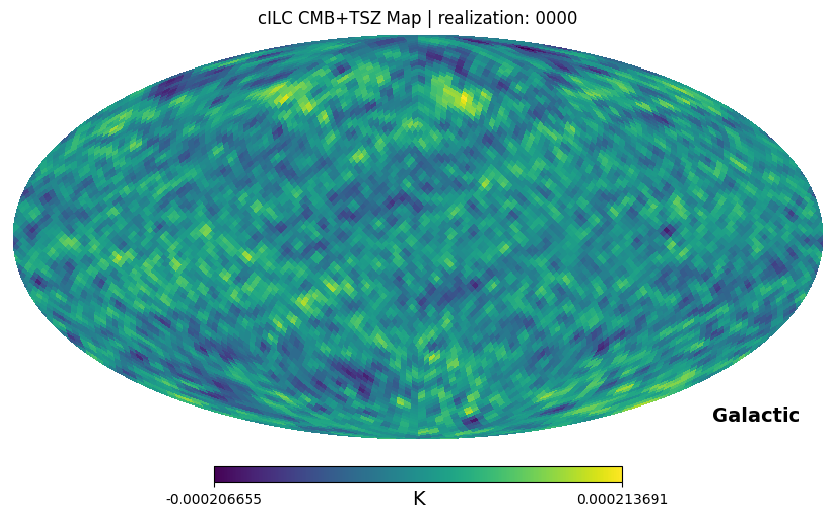

FINAL CHECK  F^T w == f  -> True


In [28]:
import numpy as np

# Frequency names
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']

# Wavelet scales
scales = [0, 1, 2, 3, 4, 5, 6]

# Realization list (strings)
realizations = ["0000"]

# Whether you're running constrained or unconstrained ILC
constraint = True  # set False for unconstrained run

# Output templates
output_templates = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

output_templates_CONSTRAINT = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_{component}_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_{component}_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_cilc_{component_name}_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R{realization}.npy"
}

# Select templates
templates = output_templates_CONSTRAINT if constraint else output_templates

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

# ---- NEW: choose one or many target components here ----
# Example A: sum-preserve CMB+tSZ
target_components = ["cmb", "tsz"]
# Example B: single CMB (uncomment to use)
# target_components = "cmb"

# For filenames: make a compact tag like "cmb+tsz" or "cmb"
component_tag = "+".join(target_components) if isinstance(target_components, (list, tuple)) else target_components

for realization in realizations:
    print(f"Processing realization {realization} for targets: {target_components}")

    constrained_maps = ILC_wav_coeff_maps_MP(
        file_template=file_template,
        frequencies=frequencies,
        scales=scales,
        realizations=[realization],
        output_templates=templates,
        L_max=64,
        N_directions=1,
        constraint=constraint,
        F=F,
        component='CSNT',
        # ---- pass the list or string directly; your finder handles both ----
        component_name=target_components,
        # If your ILC function formats templates itself, it will substitute {component_name}
        # Otherwise, you can pre-format paths using `component_tag` as needed.
    )


Processing realization 0000
Processing realization 0000 for component CSNT


MW alm shape: (64, 127)


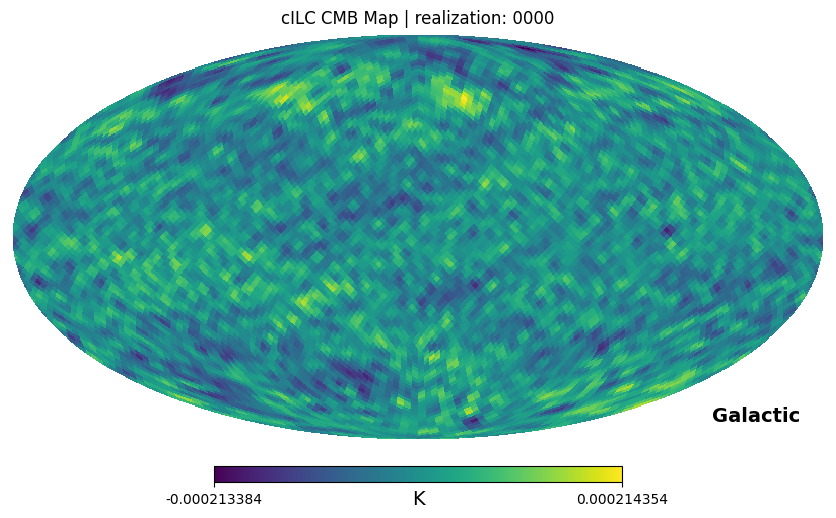

FINAL CHECK  F^T w == f  -> True


In [29]:
import numpy as np

# Frequency names
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']

# Wavelet scales
scales = [0, 1, 2, 3, 4, 5, 6]  

# Realization list
realizations = [0]

# Whether you're running constrained or unconstrained ILC
constraint = True  # change this to False for unconstrained run

# Define both output_templates versions
output_templates = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

output_templates_CONSTRAINT = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_{component}_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_{component}_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_cilc_{component_name}_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R{realization}.npy"
}


# Select appropriate output template based on constraint flag
templates = output_templates_CONSTRAINT if constraint else output_templates

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

realizations = ["0000"]  # string

for realization in realizations:
    print(f"Processing realization {realization}")

    constrained_maps = ILC_wav_coeff_maps_MP(
        file_template=file_template,
        frequencies=frequencies,
        scales=scales,
        realizations=[realization],  # string
        output_templates=templates,
        L_max=64,
        N_directions=1,
        constraint=True,
        F=F,
        component='CSNT',
        component_name='cmb'
    )

In [30]:
import numpy as np
import healpy as hp
import s2fft

def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm


def hp_alm_2_mw_alm(hp_alm, L_max):
    """
    Converts spherical harmonics (alm) to a matrix representation for use in MW sampling.

    This function takes 1D Healpix spherical harmonics coefficients (alm) and converts them into a matrix form 
    that is in (MW sampling, McEwen & Wiaux) sampling. The matrix form is complex-valued 
    and indexed by multipole moment and azimuthal index.

    Parameters:
        hp_alm (numpy.ndarray): The input healpix spherical harmonics coefficients (alm).
        L_max (int): The maximum multipole moment to be represented in the output matrix.
    
    Note: # L_max = 4 | l = 0,1,2,3 , true lmax is L_max-1 = 3 | m = -3...0...(L_max-1 = 3)| number of m = 2(L_max-1)+1 = 2L_max-1

    Returns:
        MW_alm (numpy.ndarray): 2D array of shape (Lmax, 2*Lmax-1) MW spherical harmonics coefficients 
    """

    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

MW alm shape: (64, 127)


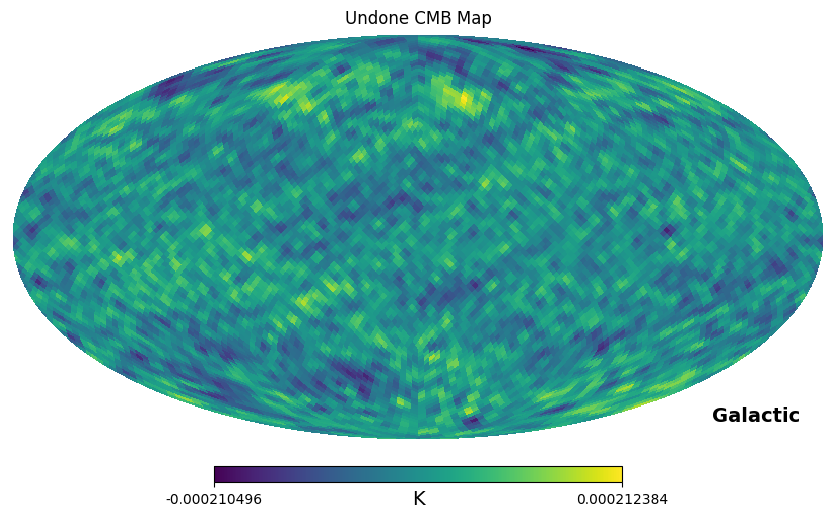

In [32]:
# --- Load MW map ---
MW_map = np.load("ILC/synthesized_ILC_MW_maps/CSNT_ILC_MW_Map_cilc_cmb_R0000_MP.npy")

L_max = 64   # adjust to your case
fwhm_rad = np.radians(1.0 / 60.0)  # 1 arcmin

# --- MW map -> alm ---
MW_alm = s2fft.forward(MW_map, L=L_max, spin=0)
hp_alm = mw_alm_2_hp_alm(MW_alm, L_max-1)

# --- Undo operations ---
pixwin = hp.pixwin(nside=64, lmax=L_max-1, pol=False)   # adjust nside if needed
Standard_bl = hp.gauss_beam(fwhm_rad, lmax=L_max-1, pol=False)

hp_alm = hp.almxfl(hp_alm, pixwin)           # undo 1/pixwin
hp_alm = hp.almxfl(hp_alm, 1.0 / Standard_bl) # undo *Standard_bl

# --- Back: hp alm -> MW alm -> MW map ---
MW_alm_new = hp_alm_2_mw_alm(hp_alm, L_max)
MW_map_new = s2fft.inverse(MW_alm_new, L=L_max, spin=0)

# --- Save ---
np.save("ILC/synthesized_ILC_MW_maps/CMB_ILC_MW_Map_cilc_cmb_R0000_MP_UNDO.npy", MW_map_new)

# --- Plot ---
visualize_MW_Pix_map(MW_map_new, "Undone CMB Map")

(64, 127)
MW alm shape: (64, 127)


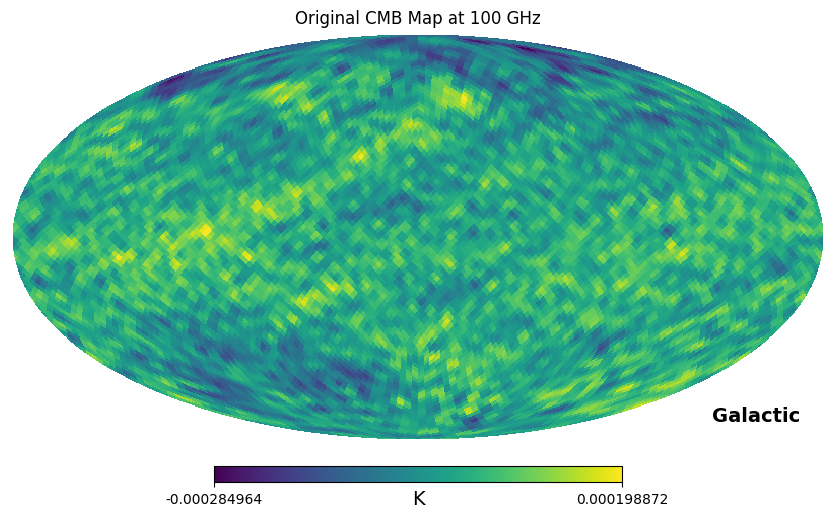

In [33]:
import numpy as np
from s2wav import synthesis, filters

component = "CMB"  

L_max = 64
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

# Load scaling coefficients
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R0000.npy")

# Load wavelet coefficients for all scales
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F100_S{scale}_R0000.npy"))
    for scale in range(7)
]

# Synthesis
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)

title = f"Original {component} Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


MW alm shape: (64, 127)


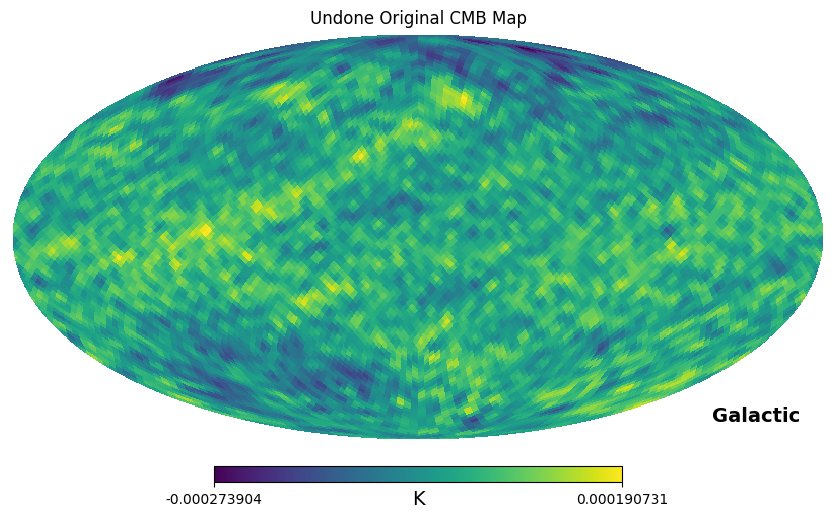

In [34]:
import numpy as np
import healpy as hp
import s2fft

# --- Start from MW_Pix directly ---
L_max = 64
fwhm_rad = np.radians(1.0 / 60.0)  # 1 arcmin

# --- MW map -> alm ---
MW_alm = s2fft.forward(MW_Pix, L=L_max, spin=0)
hp_alm = mw_alm_2_hp_alm(MW_alm, L_max - 1)

# --- Undo operations ---
nside = L_max // 2   # ✅ valid Healpix nside
pixwin = hp.pixwin(nside=nside, lmax=L_max - 1, pol=False)
Standard_bl = hp.gauss_beam(fwhm_rad, lmax=L_max - 1, pol=False)

hp_alm = hp.almxfl(hp_alm, pixwin)             # undo 1/pixwin
hp_alm = hp.almxfl(hp_alm, 1.0 / Standard_bl)  # undo *Standard_bl

# --- Back: hp alm -> MW alm -> MW map ---
MW_alm_new = hp_alm_2_mw_alm(hp_alm, L_max)
MW_Pix_new = s2fft.inverse(MW_alm_new, L=L_max, spin=0)

# --- Save ---
np.save("ILC/synthesized_ILC_MW_maps/CMB_MW_Pix_UNDO.npy", MW_Pix_new)

# --- Plot ---
visualize_MW_Pix_map(MW_Pix_new, "Undone Original CMB Map")
